<a href="https://colab.research.google.com/github/kozen88/ProgettoIcon2023/blob/main/Cost_sensitive_learning_WORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COST SENSITIVE LEARNING PER AFFRONTARE l'IMBALANCE LEARNING
In questo notebook andremo ad utilizzare i dataset già preprocessati precedentemente e applicheremo modelli di apprendimento supervisionato con cost sensitive learning.

- COST SENSITIVE LEARNING: <p align="justify"> è una tecnica con la quale si marcano gli errori associandoli ad un peso differrente per ciascuna delle due classi, l'idea è quella di marcare con un peso più pesante e quindo andando a marcare un errore come più grave gli esempi della classe minoritaria di  modo che se il modello sbaglia a classificare questi esempi riceverà un feedback dal peso associato all'errore commesso che gli farà adattare la sua strategia di classificazione.

<p align="justify">NOTA: nella libreira che stiamo usando per il progetto ovvero scikit-learn offre a disposizione per la maggiorparte dei modelli una istanziazione con il parametro cost_sensitive che permette di apllicare il cost sensitve learning, tuttavia non tutti i modelli presenti nella libreria offrono questa implementazione e sfortunatamento il Gaussian Naive Bayes usato nei precedenti espereìimentri non dispone di tale parametro per tali ragioni in questo notebook metteremo a confronto nuovi classificatori.

In [1]:
from ast import increment_lineno
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate,cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import precision_score, f1_score, fbeta_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
sns.set_style('darkgrid')

In [2]:
df_impiegati = pd.read_excel('Impiegati_one_hot_standardize.xlsx')
# Rimescola il DataFrame in modo casuale
df_impiegati = df_impiegati.sample(frac=1, random_state=42)

## BREVE VISUALIZZAZIONE DELLO SBILANCIAMENTO
Qui andiamo a ricapitolare come appare il nostro dataset dopo le elaborazioni fatte in precedenza e andaimo a inquadrare nuovamente la sitauzione di sbilancio del dataset prima di anandare ad applicare l'addestramento

In [ ]:
df_impiegati

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department_RandD,department_accounting,department_human_resources,department_management,department_marketing,department_product_mng,department_sales,department_technical,salary_high,salary_low,salary_medium,left
6723,0.149490,1.424944,0.971113,0.499578,-1.026126,2.432112,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,4.059723,-0.252953,-0.617455,-0.836653,-0.299809,-0.975824,1.151898,0
6473,1.074587,0.490165,-0.651538,-0.701829,-1.026126,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,-0.617455,1.195238,-0.299809,1.024775,-0.868132,0
4679,0.310376,1.541791,-0.651538,0.259297,-1.026126,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.836653,-0.299809,1.024775,-0.868132,0
862,-0.815830,-1.437818,-1.462863,-0.942110,-0.341235,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.836653,-0.299809,1.024775,-0.868132,1
7286,1.034366,0.256470,0.971113,1.060235,-1.026126,2.432112,-0.147412,-0.235321,-0.232148,4.392761,-0.209391,-0.246322,-0.252953,-0.617455,-0.836653,-0.299809,1.024775,-0.868132,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,-0.373392,1.424944,0.159788,0.900048,-0.341235,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,-0.617455,1.195238,-0.299809,1.024775,-0.868132,0
13418,-0.494057,-0.386191,0.159788,0.639743,2.398327,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.836653,-0.299809,-0.975824,1.151898,0
5390,0.189711,0.081199,0.971113,0.960118,-1.026126,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,-0.617455,1.195238,-0.299809,-0.975824,1.151898,0
860,0.712593,1.658639,0.159788,0.339391,1.028546,-0.411165,-0.147412,-0.235321,-0.232148,-0.227647,-0.209391,-0.246322,-0.252953,1.619551,-0.836653,-0.299809,1.024775,-0.868132,1


In [3]:
def plot_class_distribution(class_counts, title):
    plt.figure(figsize=(6, 4))
    ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette="pastel", alpha=0.8)
    plt.xlabel('Classe\nRestano=0  vs  Lasciano=1')
    plt.ylabel('Numero di impiegati per classe')
    plt.title(title)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

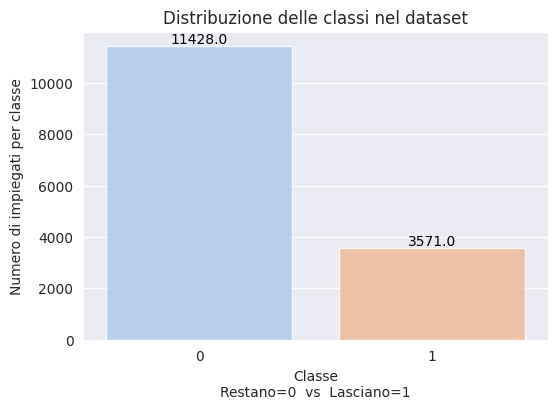

In [4]:
class_counts_check = df_impiegati['left'].value_counts()

# Crea un barplot per mostrare lo sbilanciamento tra le classi
plot_class_distribution(class_counts_check, 'Distribuzione delle classi nel dataset')

In [5]:
def plot_pie_chart(class_counts, title, legend_labels, startangle=40, fontsize=12, fontweight='bold'):
    plt.figure(figsize=(6, 6))
    colors = sns.color_palette('pastel')
    sns.set_palette(colors)

    def func(pct, allvalues):
        absolute = int(pct / 100. * np.sum(allvalues))
        return f"{pct:.2f}%\n({absolute:,d})"

    explode = (0.02,) + (0,) * (len(class_counts) - 1)  # Add space only to the first slice

    plt.pie(class_counts, labels=class_counts.index, autopct=lambda pct: func(pct, class_counts), startangle=startangle,
            textprops={'fontsize': fontsize, 'fontweight': fontweight}, explode=explode, shadow=True)

    plt.title(title)
    plt.axis('equal')

    plt.legend(legend_labels, loc='lower right')  # Custom legend

    plt.show()

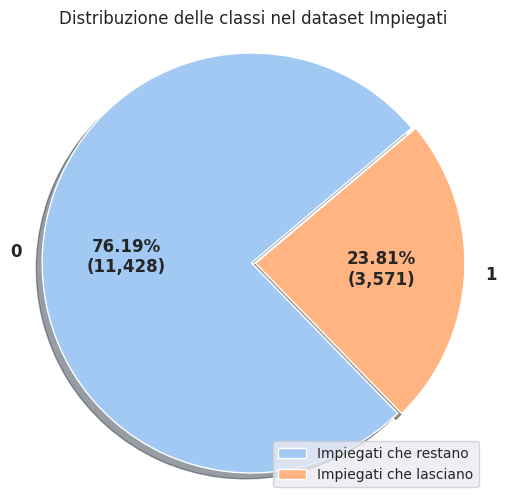

In [6]:
legend_labels = ['Impiegati che restano', 'Impiegati che lasciano']
plot_pie_chart(class_counts_check, 'Distribuzione delle classi nel dataset Impiegati', legend_labels, startangle=40, fontsize=12, fontweight='bold')

## COST INSENSITIVE LEARNING
<p align="justify"> Inizieremo il nostro studio per affrontare lo sbilanciamento del dataset partendo dall'addesttramento dei 2 modelli sopra elencati vedrremo il loro comportamento durante l'addestramento e le loro performance sul trian set e sul test set in modo da avere una baseline delle loro performance e da li capire se in seguito applicando un peso sulle classi le performance possano migliorare.

Di seguito si riportano delle funzioni di suppurto per la valutazione dei risultati dopo l'addestramento dei modelli

In [7]:
def stampa_metriche(pred_train, pred_test, y_train, y_test, model):
    # Calcola e stampa l'accuracy per il train set e il test set
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_test = accuracy_score(y_test, pred_test)
    print("----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------")
    print(f"Modello valutato: {model}")
    print(f'Accuracy (Train): {accuracy_train}')
    print(f'Accuracy (Test): {accuracy_test}')

    # Calcola e stampa precision, recall, e F1-score per il train set e il test set
    precision_train = precision_score(y_train, pred_train, average='macro')
    recall_train = recall_score(y_train, pred_train, average='macro')
    f1_train = f1_score(y_train, pred_train, average='macro')

    precision_test = precision_score(y_test, pred_test, average='macro')
    recall_test = recall_score(y_test, pred_test, average='macro')
    f1_test = f1_score(y_test, pred_test, average='macro')

    print(f'Precision (Train): {precision_train}')
    print(f'Precision (Test): {precision_test}')
    print(f'Recall (Train): {recall_train}')
    print(f'Recall (Test): {recall_test}')
    print(f'F1-Score (Train): {f1_train}')
    print(f'F1-Score (Test): {f1_test}')

    # Stampa classification report per il train set e il test set
    print('Classification Report (Train):\n', classification_report(y_train, pred_train))
    print('Classification Report (Test):\n', classification_report(y_test, pred_test))

In [8]:
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', fontsize=22, title_color='#660000'):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Calcola le percentuali
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap='OrRd')  # Utilizza fmt=".2%" per visualizzare le percentuali con due decimali
    plt.title(title, fontsize=fontsize, color=title_color)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [9]:
# Questa funzione permette di andare a creare il plot per la valutazione di una curva di apprendimento
def train_and_plot_progress_with_custom_metric(model, X_train, y_train, metric_func, metric_label, step_size=50):
    num_examples = []
    metric_values = []

    for num_samples in range(step_size, len(X_train) + 1, step_size):
        # Addestra il modello sui primi num_samples esempi
        model.fit(X_train[:num_samples], y_train[:num_samples])

        # Calcola la metrica specificata sul set di addestramento
        metric = metric_func(y_train[:num_samples], model.predict(X_train[:num_samples]))

        num_examples.append(num_samples)
        metric_values.append(metric)

    # Traccia il grafico dell'andamento dell'addestramento
    plt.figure(figsize=(10, 6))
    plt.plot(num_examples, metric_values, marker='o')
    plt.title('Andamento dell\'addestramento')
    plt.xlabel('Numero di Esempi di Addestramento')
    plt.ylabel(metric_label)
    plt.grid(True)
    plt.show()

In [10]:
# Questa funzionne come la precedente va a verificare l'apprendimento plottando la curva di apprendimento ma ristretta ad un numero limitato
# di esempi e con un passo di valutazione più stretto
def train_and_plot_limited_data(model, X_train, y_train, metric_func, metric_label, max_samples=1000, step_size=10):
    num_examples = []
    metric_values = []

    for num_samples in range(step_size, max_samples + 1, step_size):
        num_samples = min(num_samples, max_samples)  # Limita il numero di esempi a max_samples se supera questo valore
        # Addestra il modello sui primi num_samples esempi
        model.fit(X_train[:num_samples], y_train[:num_samples])

        # Calcola la metrica specificata sul set di addestramento
        metric = metric_func(y_train[:num_samples], model.predict(X_train[:num_samples]))

        num_examples.append(num_samples)
        metric_values.append(metric)

    # Traccia il grafico dell'andamento dell'addestramento
    plt.figure(figsize=(10, 6))
    plt.plot(num_examples, metric_values, marker='o')
    plt.title('Andamento dell\'addestramento')
    plt.xlabel('Numero di Esempi di Addestramento')
    plt.ylabel(metric_label)
    plt.grid(True)
    plt.show()

- Preparazione feature di input e feature di output e divisione tramite hold-out

In [11]:
# Separiamo input da output prima di iniziare l'addesttramento
X = df_impiegati.drop("left", axis=1)
y = df_impiegati["left"]

In [12]:
# Andiamo a suddividere il dataset in train set e test set con un hold-out 70:30
X_train, X_test, y_train, y_test  = train_test_split (X, y, test_size=0.3, random_state=30)

# verifica del hold out
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train.shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (10499, 18)
X_test shape:  (4500, 18)
y_train.shape:  (10499,)
y_test shape:  (4500,)


## STOCHASTIC GRADIENT DESCENT STUDIO DELLE CURVE DI APPRENDIMENTO
<p align="justify"> Andremo a studiare l'aprendimento del modello all'aumentare dei dati visti durante il training e in particolare andremo a studiare le curve di apprendimento in base alle seguenti metriche:

- Recall
- Precision
- Accuracy

<p align="justify"> Si evidenzia che la più significativa per noi è il recall per quanto affermato all'inizio dei nostri eserimenti, e si evidenzia come nei task sbilanciati l'accuracy sia una metrica poco affidabile poiché necessitiamo di avere una situazione chiara sulle performance relative ad ogni classe cosa che tale metrica non riesce a fare, per tale ragione poiché in questo notebook non stiamo applicando strategie di campionamento atte a cercare di bilanciare le classi eviteremo di studiare le curve dell'accurancy che risulterebbero poco significative, mentre studieremo questa metrica nella sezione delle tecniche di campionamento.

- Studio curve di apprendimento su Recall

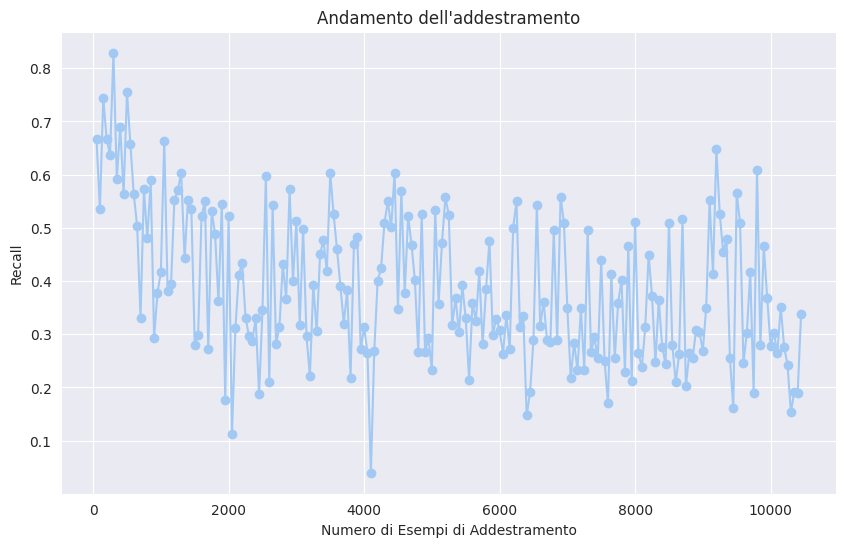

In [ ]:
train_and_plot_progress_with_custom_metric(SGDClassifier(random_state=30), X_train, y_train, recall_score, "Recall")

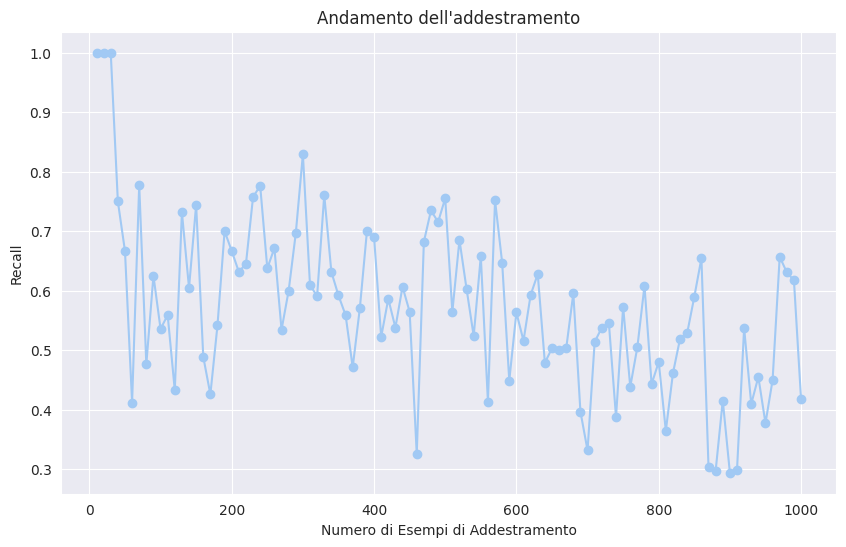

In [ ]:
train_and_plot_limited_data(SGDClassifier(random_state=30), X_train, y_train, recall_score, "Recall", max_samples=1000)

Osservazione sulle curve di addestramento per lo stochastic gradient descent:

 - <p align="justify">CURVA DI TRAIN SU RECALL: Da i grafici plottati si capisce come il modello stia avendo grosse difficoltà di apprendimento e infatti sia sul breve termine dopo pochi esempi che su lungo termine dopo aver visto più della metà degli esempi del data set le valutazioni del recall continuano ad oscillare bruscamente tra il 20% e il 60%.

- Studio curve di apprendimento su Precision

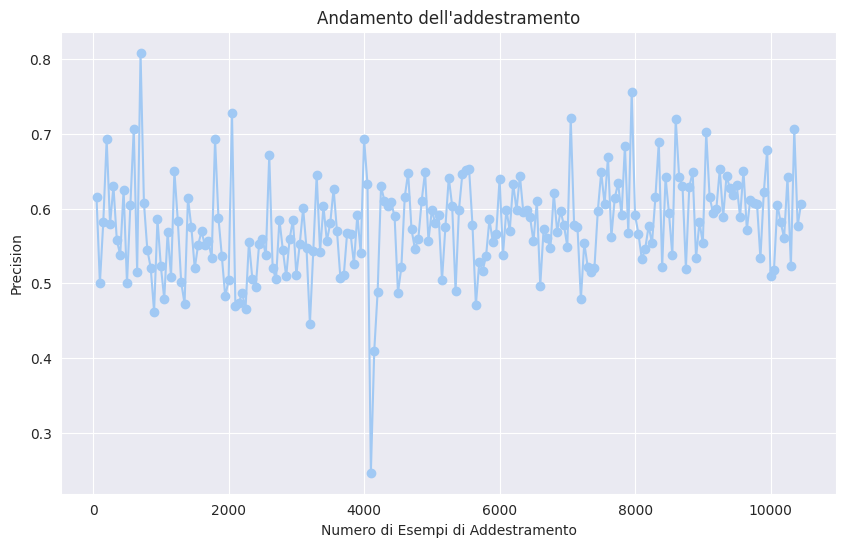

In [ ]:
train_and_plot_progress_with_custom_metric(SGDClassifier(random_state=30), X_train, y_train, precision_score, "Precision")

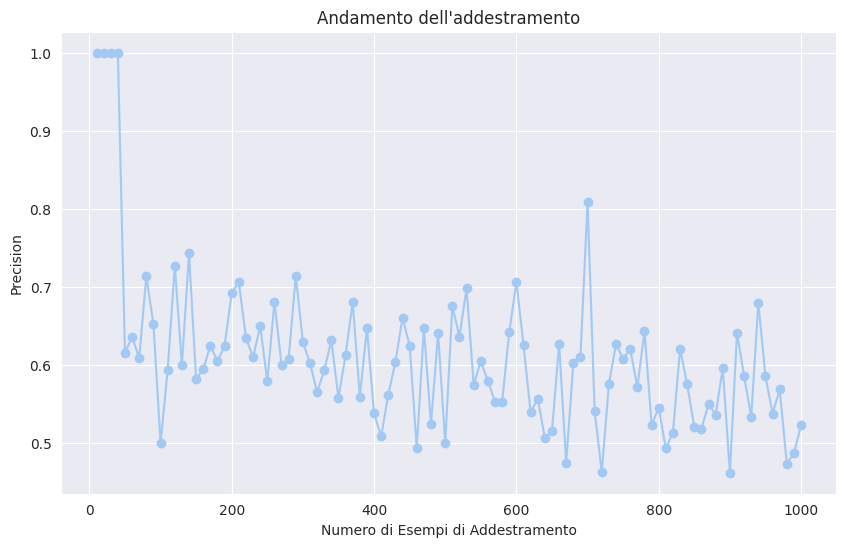

In [ ]:
train_and_plot_limited_data(SGDClassifier(random_state=30), X_train, y_train, precision_score, "Precision", max_samples=1000)

Osservazione sulle curve di addestramento per lo stochastic gradient descent:

- <p align="justify">CURVA DI TRAIN SU PRECISION: anche per la precision i grafici mostrano lo stesso problema riscontrato sul recall, anche se meno accentuato di fatto le escursioni sono comprese prevalentemente tra 70% e 50% il problema penso sia dovuto allo sbilanciamento esistente tra le due classi che influenza negativamente l'apprndimento.

## PERCETTRONE STUDIO DELLE CURVE DI APPRENDIMENTO
Ripeteremo lo studio precedente anche per questo modello per vedere il suo comportamento.

- Studio delle curve di apprendimento su Recall

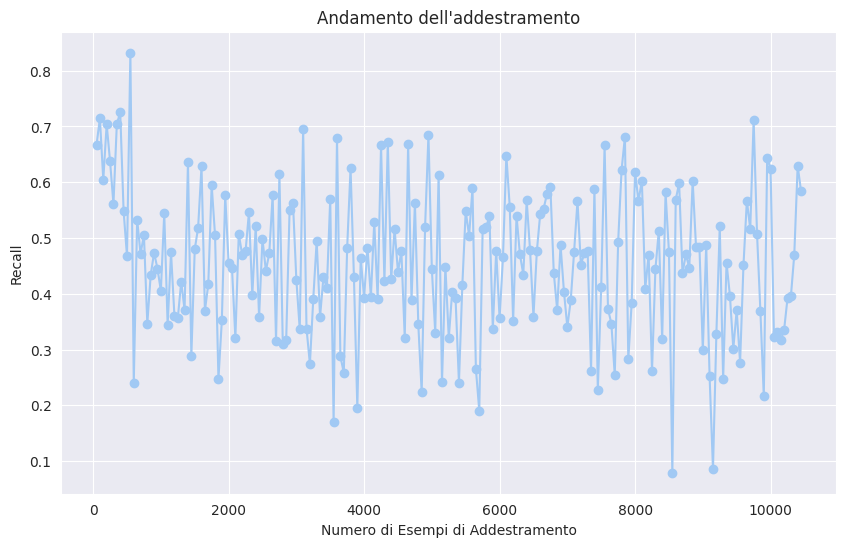

In [ ]:
train_and_plot_progress_with_custom_metric(Perceptron(random_state=30), X_train, y_train, recall_score, "Recall")

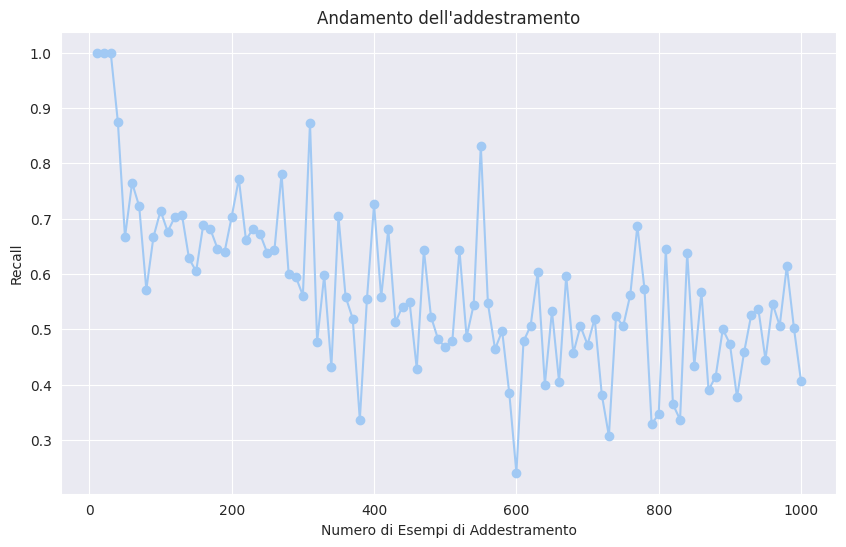

In [ ]:
train_and_plot_limited_data(Perceptron(random_state=30), X_train, y_train, recall_score, "Recall", max_samples=1000)

Osservazione sulle curve di addestramento per il percettrone:

 - <p align="justify">CURVA DI TRAIN SU RECALL: anche per il percettrone notiamo un andamento oscillatorio che denota sicuramente problematiche nell'apprendimento dovute allo sbilanciamento.

- Studio delle curve di apprendimento su Precision

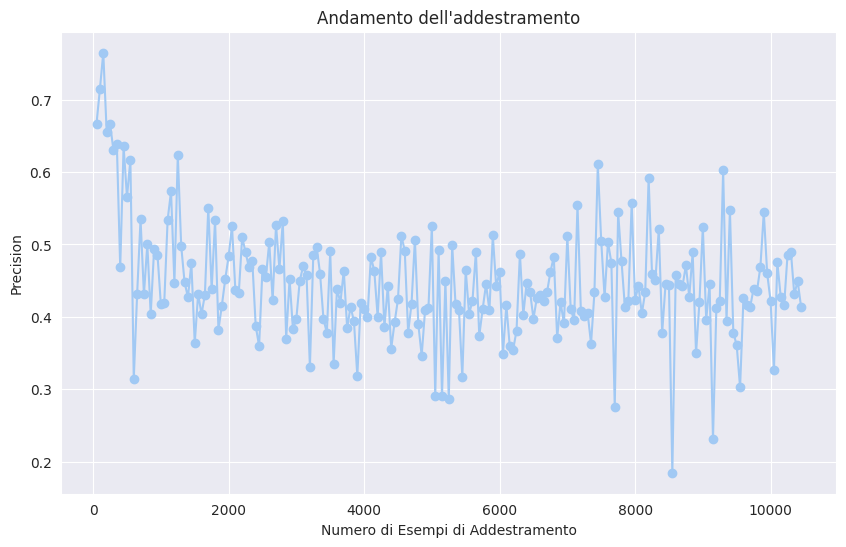

In [ ]:
train_and_plot_progress_with_custom_metric(Perceptron(random_state=30), X_train, y_train, precision_score, "Precision")

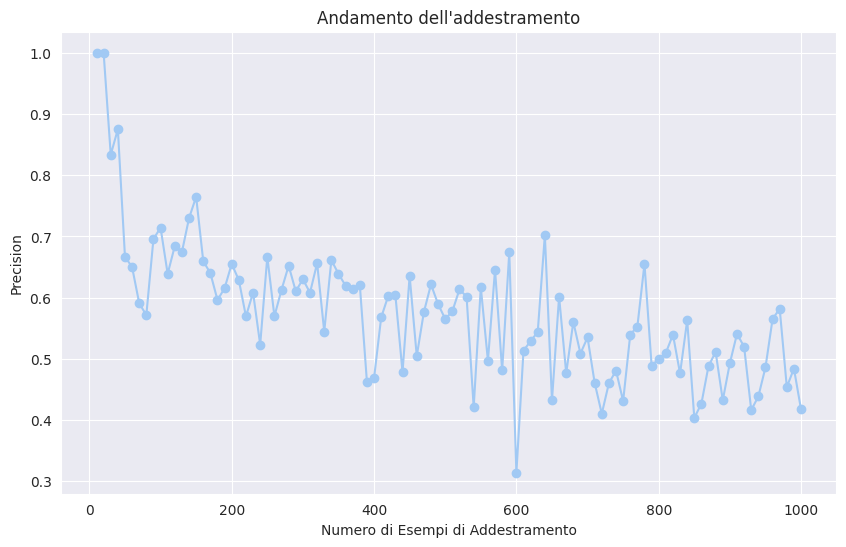

In [ ]:
train_and_plot_limited_data(Perceptron(random_state=30), X_train, y_train, precision_score, "Precision", max_samples=1000)

Osservazione sulle curve di addestramento per il percettrone:

- <p align="justify">CURVA DI TRAIN SU PRECISION: anche sul grafico della precision notiamo gli stessi problemi che diventano persino più marcati nel percettrone rispetto allo stochastic gradient descent, oscillando tra il 70% e il 30%.

## ADDESTRAMENTO E CONFRONTO TRA I MODELLI CON COST INSENSITIVE
Procediamo all'addestramento e al confronto dei modelli utilizzando le classiche metriche di valutazione e le matrici di confusione eseguiremo infine un confronto con lo score ROC.

In [21]:
# istanziazzione dei modelli da mettere a confronto
sgdc = SGDClassifier(loss='log', random_state=30)
perceptron = Perceptron(random_state=30)

# adestramento base su hold-out per stochastic gradient descent
sgdc.fit(X_train, y_train)
pred_train_sgdc = sgdc.predict(X_train)
pred_test_sgdc = sgdc.predict(X_test)


# adestramento base su hold-out per percettrone
perceptron.fit(X_train, y_train)
pred_train_perceptron = perceptron.predict(X_train)
pred_test_perceptron = perceptron.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [22]:
# Utilizzo della funzione per mostrare le predizioni a confronto tra train e test
stampa_metriche(pred_train_sgdc, pred_test_sgdc, y_train, y_test, "STOCHASTIC GRADIENT DESCENT")

----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------
Modello valutato: STOCHASTIC GRADIENT DESCENT
Accuracy (Train): 0.8025526240594343
Accuracy (Test): 0.81
Precision (Train): 0.7324278822868435
Precision (Test): 0.7374208337505235
Recall (Train): 0.678902976111833
Recall (Test): 0.6860250230725734
F1-Score (Train): 0.6967230470090817
F1-Score (Test): 0.7039872513329422
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      7977
           1       0.63      0.44      0.52      2522

    accuracy                           0.80     10499
   macro avg       0.73      0.68      0.70     10499
weighted avg       0.79      0.80      0.79     10499

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.85      0.92      0.88      3451
           1       0.63      0.45      0.53      1049

    accuracy                           0.81      4500
   macro avg  

Non ci sono variazioni tra il train e il test, sospettiamo che il dataset sul quale stiamo lavorando sia un dataset sperimentale a scopo educativo, dato che molti dei modelli non riportano signioficative differenze tra le performance di train e quelle di test.

In [23]:
print("_____STOCHASTIC GRADIENT DESCENT COST INSENSITIVE_______")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_test_sgdc))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_test_sgdc))

_____STOCHASTIC GRADIENT DESCENT COST INSENSITIVE_______
------------------------Accuracy------------------------

0.81

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      3451
           1       0.63      0.45      0.53      1049

    accuracy                           0.81      4500
   macro avg       0.74      0.69      0.70      4500
weighted avg       0.80      0.81      0.80      4500



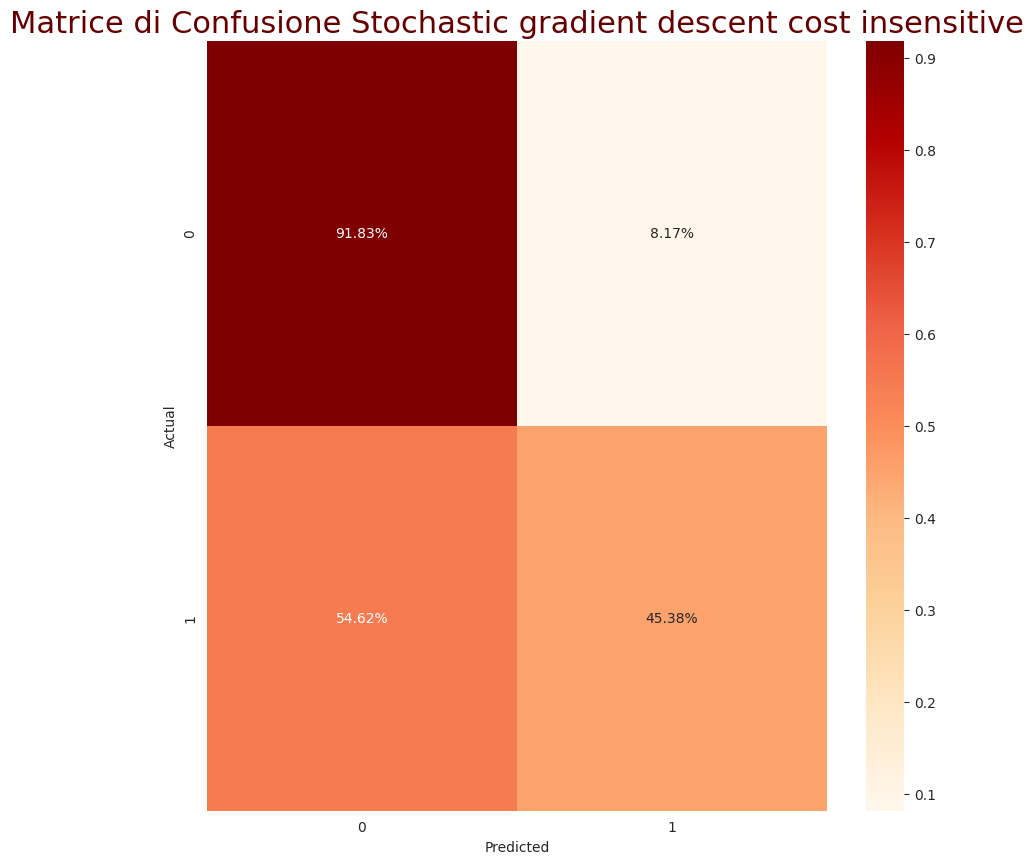

In [24]:
plot_confusion_matrix(y_test, pred_test_sgdc, "Matrice di Confusione Stochastic gradient descent cost insensitive")

Andiamo a creare una funzione che ci permetta di valutare sperimentalmente quale sia il miglior k come numero per i ffold della convalida incrociata che andremo ad utilizzare per la convalida dei risultati ottenuti  con l'hold out, di seguito andremo a valutare i migliori fold in base alle due metriche recall e precision senza considerare l'accuracy dato che il dataset è sbilanciato.

In [15]:
# la funzione eseguirà l'addestramento del modello usato una cross validartion stratificata
# e andra a plottare un grafico che mostrerà i risultati dell'addestramento in base ad una
# metrica che si vuole massimizzare
# occhio questa funzione necessita di array numpy e non di data frame!!!!!!!
def kfold_crossval_plot(X, y, model, metric_function, metric_name, k_range):

    metric_scores = []
    num_folds_used = []

    for k in k_range:
        kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        fold_metrics = []

        for train_index, val_index in kf.split(X, y):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            metric = metric_function(y_val, y_pred)

            fold_metrics.append(metric)

        avg_metric = np.mean(fold_metrics)
        metric_scores.append(avg_metric)
        num_folds_used.append(k)

    plt.figure(figsize=(10, 6))
    plt.plot(num_folds_used, metric_scores, marker='o')
    plt.xlabel("Numero di Folds (k)")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} in Base al Numero di Folds (k)")
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

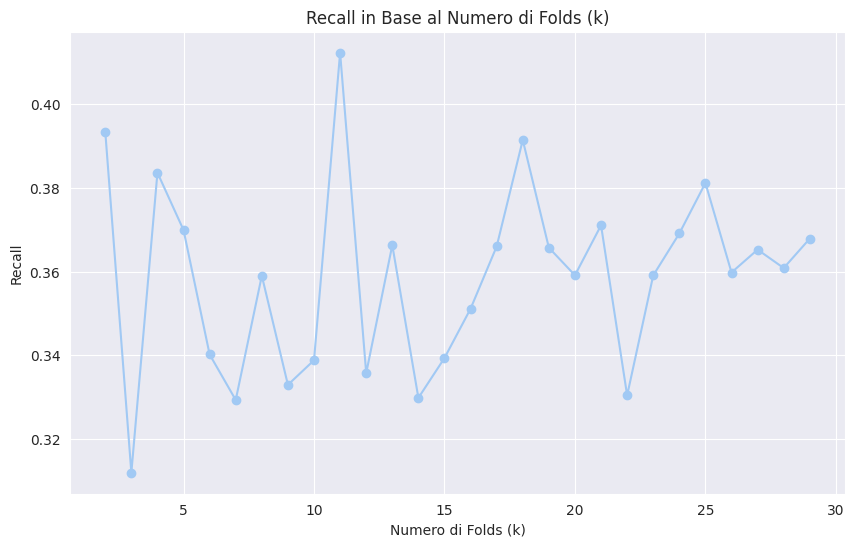

In [16]:
# X_array e y_array sono usati per far funzionare al meglio la funzione che invocheremo per lo studio del migliore fold per la convalida incrociata
X_array = X.values
y_array = y.values
kfold_crossval_plot(X_array, y_array, SGDClassifier(loss='log', random_state=30), recall_score, "Recall", range(2,30))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

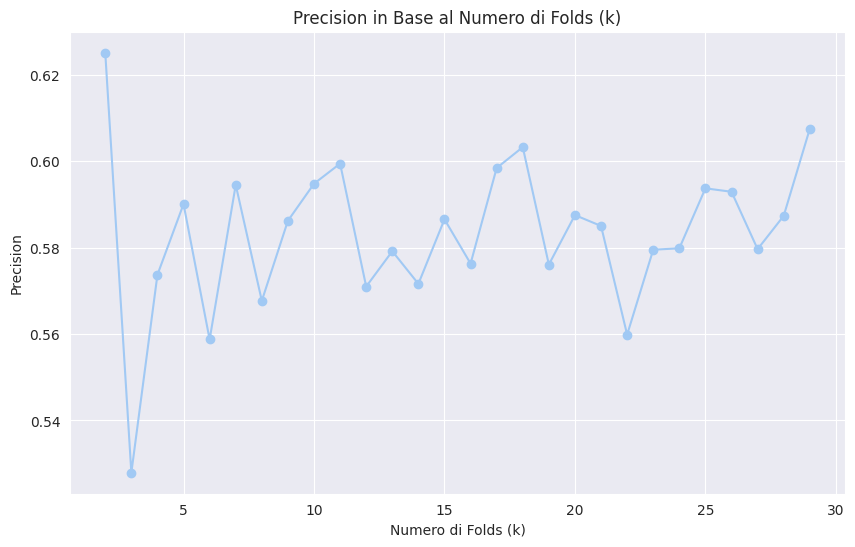

In [25]:
kfold_crossval_plot(X_array, y_array, SGDClassifier(loss='log', random_state=30), precision_score, "Precision", range(2,30))

Utilizziamo la convalida incrociata con il numero di fold k = 11 datoci dallo studio di ottimizzazione della cross validation sulle metriche di recall e precision.

In [26]:
sdgc_basal_cv_score = cross_val_score(SGDClassifier(loss='log', random_state=30), X, y, cv=11, scoring='recall')
print("Stochastic Gradient Descent Cross Validation Recall scores are: {}".format(sdgc_basal_cv_score ))
print("Stocastic Gradient Descent Average Cross Validation Recall score: {}".format(sdgc_basal_cv_score.mean()))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

Stochastic Gradient Descent Cross Validation Recall scores are: [0.24307692 0.39076923 0.50153846 0.28923077 0.39692308 0.44
 0.50617284 0.5154321  0.31790123 0.29938272 0.48615385]
Stocastic Gradient Descent Average Cross Validation Recall score: 0.3987801087801088


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


La convalida incrociata mostra come lo stochastic gradient descent ottenga prestazione in media leggermente più basse di quelle ottenute con l'hold out.

In [ ]:
# Utilizzo della funzione per mostrare le predizioni a confronto tra train e test
stampa_metriche(pred_train_perceptron, pred_test_perceptron, y_train, y_test, "PERCETTRONE")

----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------
Modello valutato: PERCETTRONE
Accuracy (Train): 0.7687398799885703
Accuracy (Test): 0.7804444444444445
Precision (Train): 0.6756544431582321
Precision (Test): 0.6881885670747143
Recall (Train): 0.6512284972348634
Recall (Test): 0.6694093172590031
F1-Score (Train): 0.660563470903042
F1-Score (Test): 0.6773131551718732
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      7977
           1       0.52      0.43      0.47      2522

    accuracy                           0.77     10499
   macro avg       0.68      0.65      0.66     10499
weighted avg       0.76      0.77      0.76     10499

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      3451
           1       0.53      0.46      0.49      1049

    accuracy                           0.78      4500
   macro avg    

Anche per il percettrone sinota la stranezza come per lo stochastic gradient descent a riguardo delle differenze sulle performance tra train e test.

In [ ]:
print("_____________PERCETTRONE COST INSENSITIVE_______________")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_test_perceptron))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_test_perceptron))

_____________PERCETTRONE COST INSENSITIVE_______________
------------------------Accuracy------------------------

0.7804444444444445

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      3451
           1       0.53      0.46      0.49      1049

    accuracy                           0.78      4500
   macro avg       0.69      0.67      0.68      4500
weighted avg       0.77      0.78      0.77      4500



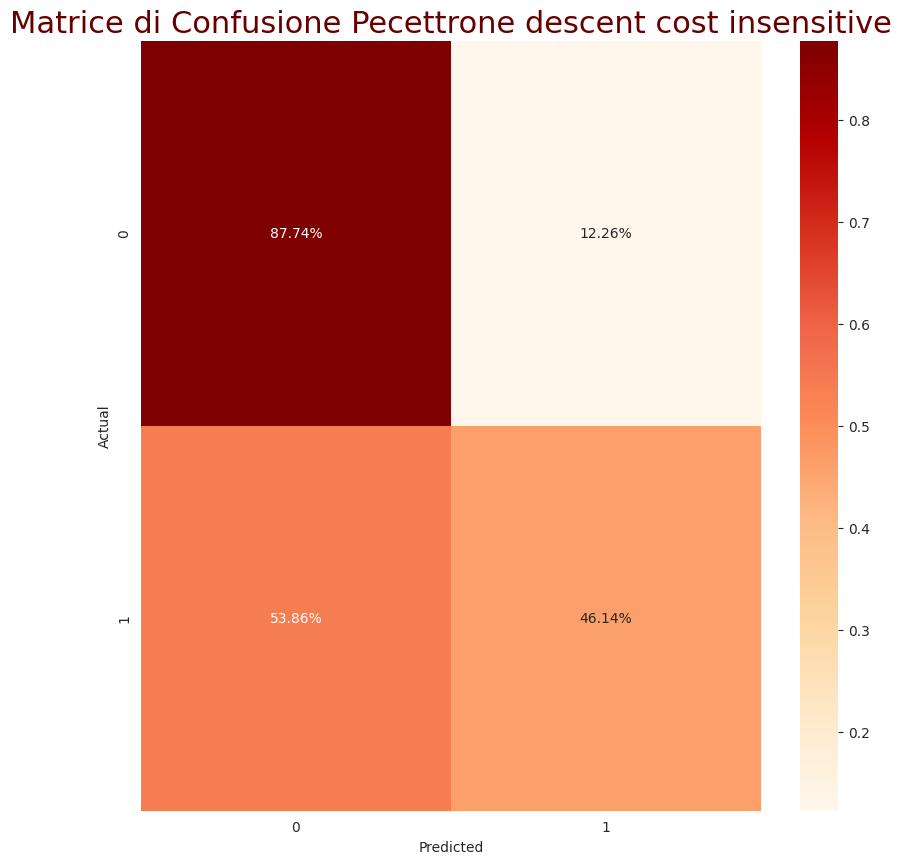

In [ ]:
plot_confusion_matrix(y_test, pred_test_perceptron, "Matrice di Confusione Pecettrone descent cost insensitive")

Andiamo a studiare quale sia il miglior fold per effettuare la convalida incrociata per il percettrone

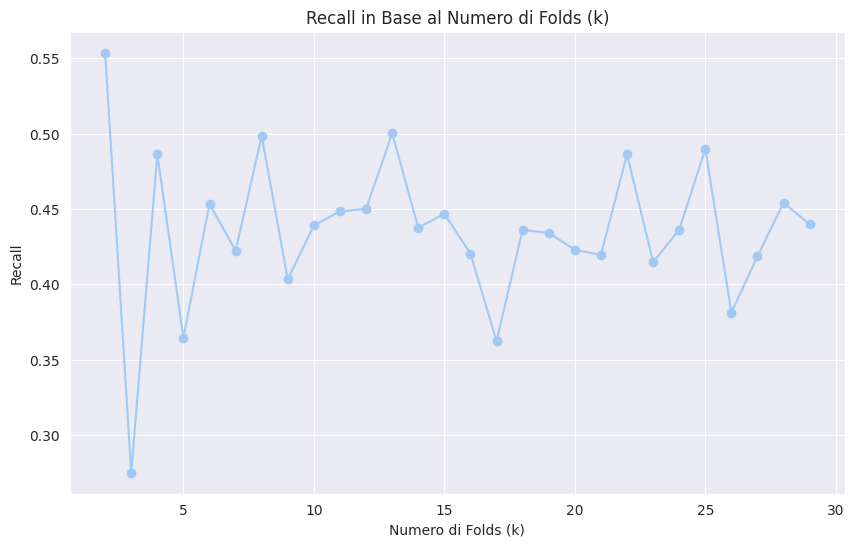

In [27]:
kfold_crossval_plot(X_array, y_array, Perceptron(random_state=30), recall_score, "Recall", range(2,30))

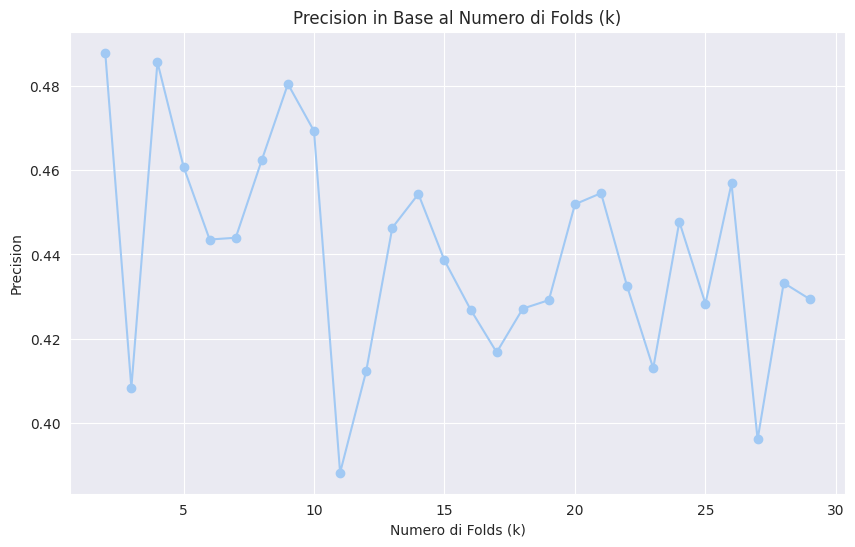

In [28]:
kfold_crossval_plot(X_array, y_array, Perceptron(random_state=30), precision_score, "Precision", range(2,30))

In [29]:
percettrone_basal_cv_score = cross_val_score(Perceptron(random_state=30), X, y, cv=8, scoring='recall')
print("Percettrone Cross Validation Recall scores are: {}".format(percettrone_basal_cv_score))
print("Percettrone Average Cross Validation Recall score: {}".format(percettrone_basal_cv_score.mean()))

Percettrone Cross Validation Recall scores are: [0.27130045 0.30269058 0.25784753 0.23766816 0.28187919 0.17225951
 0.51230425 0.34529148]
Percettrone Average Cross Validation Recall score: 0.29765514491227013


La convalida incrociata per il percettrone mostra che il precedente hold out è stato un caso fortuito e in media le prestazioni sembrano essere peggiori rispetto al modello addestrato con hold out.

- CURVA ROC: Andiamo a mettere a confronto i due classificatori addestrati sul dataset per vedere chi è andato meglio e quale scegliere per il task.

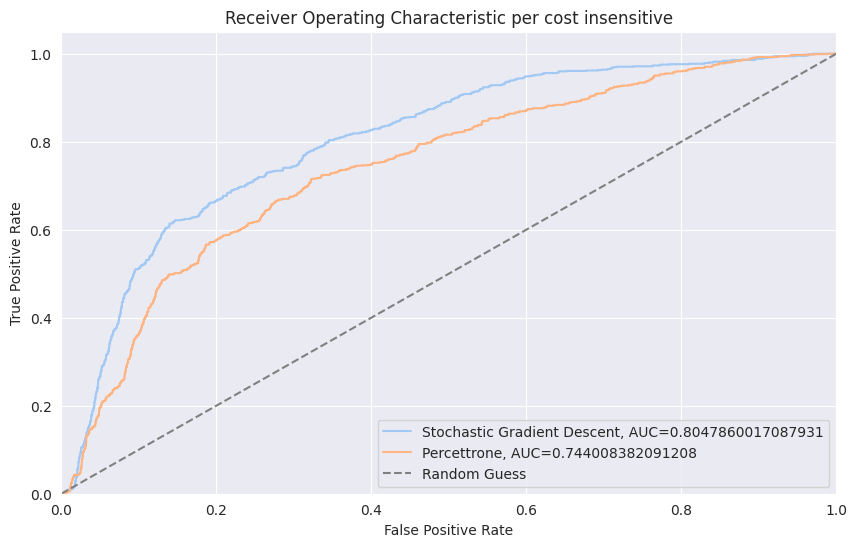

In [30]:
# Calcola i punteggi delle probabilità positive
pred_sgdc_positive = sgdc.predict_proba(X_test)[:, 1]
pred_perceptron_positive = perceptron.decision_function(X_test)

# Calcola le curve ROC e gli AUC
fpr_sgdc, tpr_sgdc, _ = roc_curve(y_test, pred_sgdc_positive)
auc_sgdc = roc_auc_score(y_test, pred_sgdc_positive)

fpr_perceptron, tpr_perceptron, _ = roc_curve(y_test, pred_perceptron_positive)
auc_perceptron = roc_auc_score(y_test, pred_perceptron_positive)

# Crea il grafico ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_sgdc, tpr_sgdc, label="Stochastic Gradient Descent, AUC=" + str(auc_sgdc))
plt.plot(fpr_perceptron, tpr_perceptron, label="Percettrone, AUC=" + str(auc_perceptron))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic per cost insensitive')
plt.legend(loc='lower right')
plt.show()

- COCNLUSIONI: <p align="justify">dopo aver addestrato entrambi i due modelli sul data set senza applicare il peso alle classi possiamo constatere dai risultati ottenuti che lo stochastic gradient descent sosfrasta il percettrone offrendo un maggiore recall punto di maggiore interesse per il problema che stiamo affrontando, ma riesce anche ad ottenere un migliore punteggio sulle altre metriche utilizzate. Quindi per il momento sembra essere il modello migliori.

## COST SENSITIVE LEARNING
<p align="justify"> Passiamo ad addestrare i precedenti modelli applicando il peso alle classi e quindi effettuando cost sensitive learning e verifichiamo le performance dei due modelli sui dati di train e quelli di test infine effettueremo un confronto tra i due modelli e mostreremo le conclusioni.

## STOCHASTIC GRADIENT DESCENT STUDIO DELLE CURVE DI APPRENDIMENTO
Andiamo ad analizzare le curve di apprendimento dopo aver addestrato il modello con approccio cost sensitive learning.

- Studio curve di apprendimento su Recall

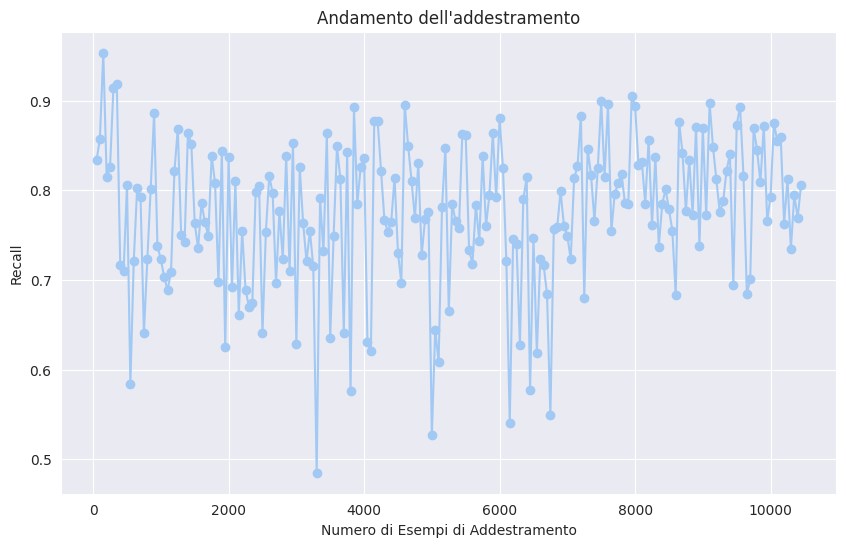

In [ ]:
train_and_plot_progress_with_custom_metric(SGDClassifier(class_weight='balanced', random_state=30), X_train, y_train, recall_score, "Recall")

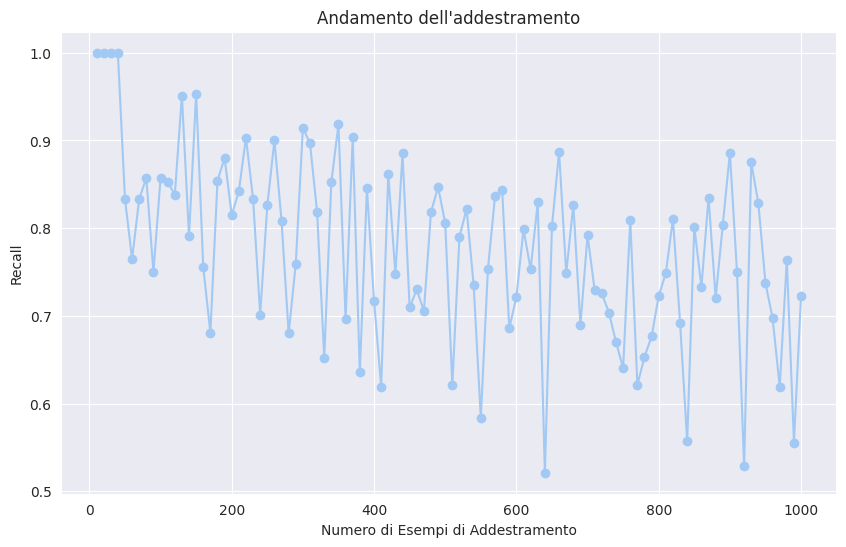

In [ ]:
train_and_plot_limited_data(SGDClassifier(class_weight='balanced', random_state=30), X_train, y_train, recall_score, "Recall", max_samples=1000)

Osservazione sulle curve di addestramento per lo stochastic gradient descent:

 - <p align="justify">CURVA DI TRAIN SU RECALL:  nei grafici di apprendimento del recall anche con strategia con sensitive possiamo notare un continua oscillazione della curva sinonimo di un cattivo apprendimento che tuttavia rispetto alla strategia insenistive sembra oscillare su percentuali più alte.

- Studio delle curve di apprendimento su Precision

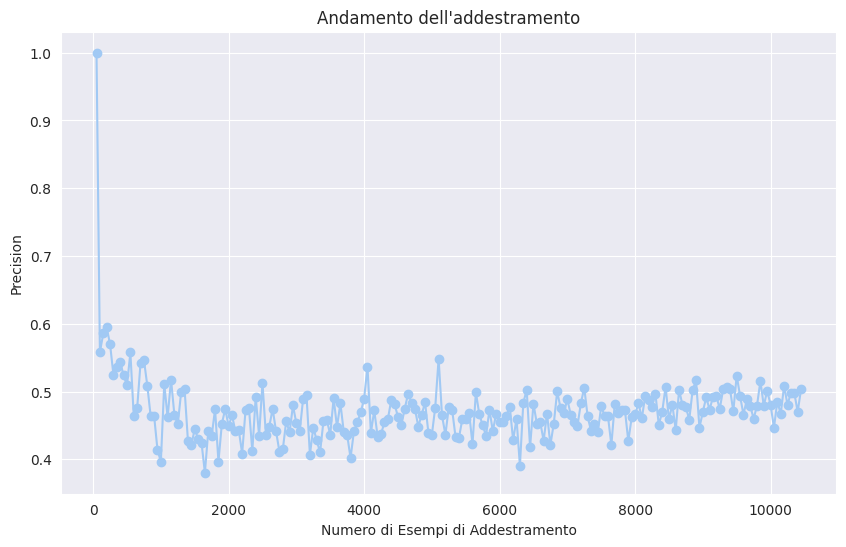

In [ ]:
train_and_plot_progress_with_custom_metric(SGDClassifier(class_weight='balanced', random_state=30), X_train, y_train, precision_score, "Precision")

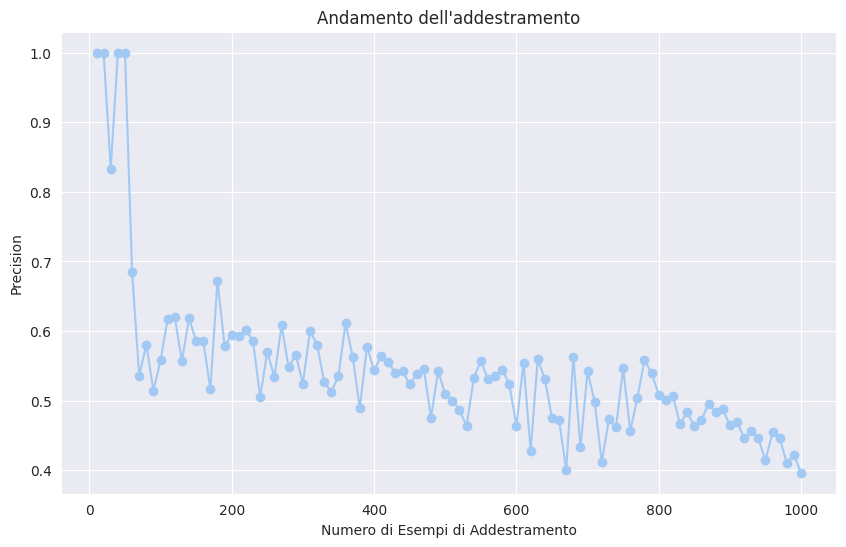

In [ ]:
train_and_plot_limited_data(SGDClassifier(class_weight='balanced', random_state=30), X_train, y_train, precision_score, "Precision", max_samples=1000)

Osservazione sulle curve di addestramento per lo stochastic gradient descent:

- <p align="justify">CURVA DI TRAIN SU PRECISION: per il grafico della precision notiamo un classico andamento della curva di precision che tende a peggiorare man mano che si vedono nuovi esempi, in questo caso sembra che la precision sia meno sensibile alle problematiche dello sbilanciamento e pur vero che continua ad oscillare, ma oscilla in un range stretto.

## PERCETTRONE STUDIO DELLE CURVE DI APPRENDIMENTO
Ripetiamo lo studio precedente anche per il percettrone per vedere il suo comportamento.

- Studio delle curve di Recall

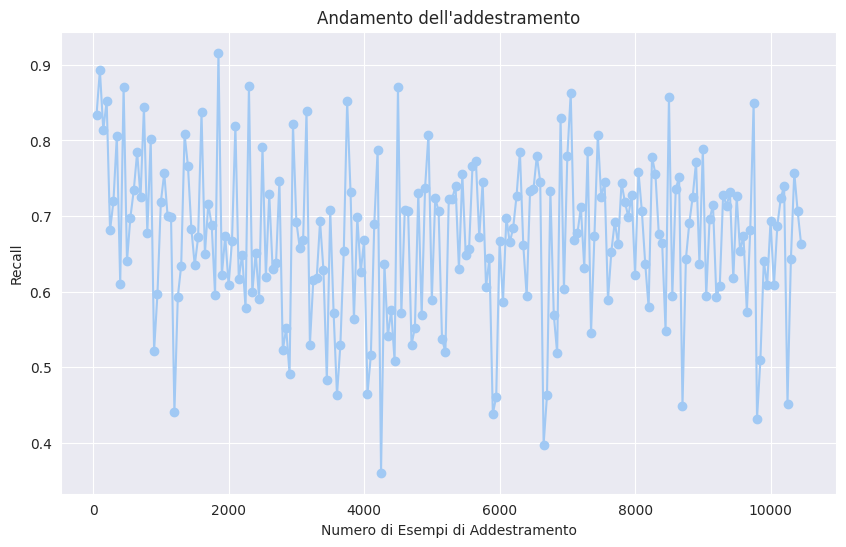

In [ ]:
train_and_plot_progress_with_custom_metric(Perceptron(class_weight='balanced', random_state=30), X_train, y_train, recall_score, "Recall")

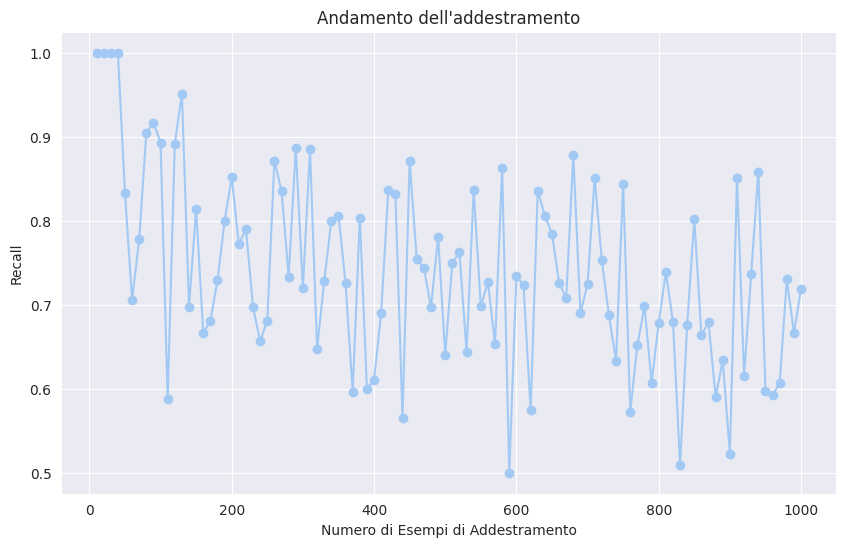

In [ ]:
train_and_plot_limited_data(Perceptron(class_weight='balanced', random_state=30), X_train, y_train, recall_score, "Recall", max_samples=1000)

Osservazione sulle curve di addestramento per il percettrone:

 - <p align="justify">CURVA DI TRAIN SU RECALL: anche per il percettrone continuano a manifestarsi problemi di apprndimento, ma le oscillazioni si sono innalzate segno che il cost sensitive ha avuto l'effetto desiderato sulle performance del classificatore.

- Studio delle curve di Precision

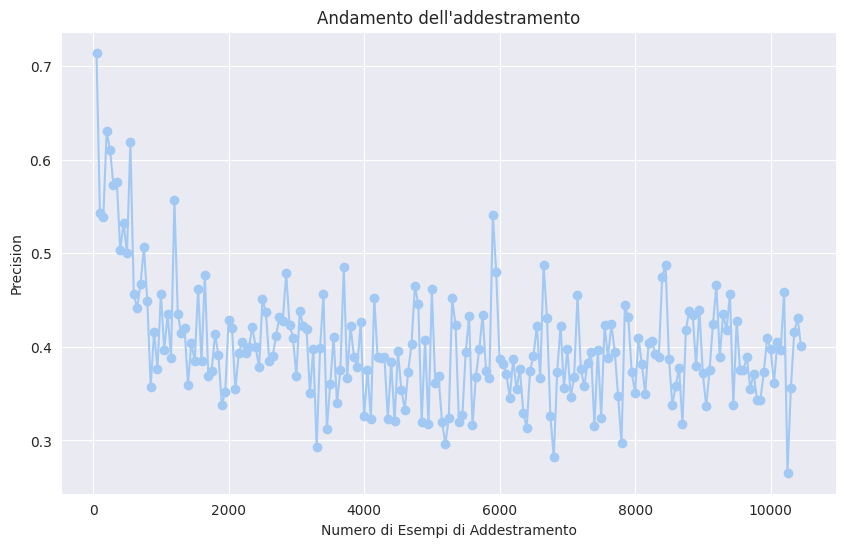

In [ ]:
train_and_plot_progress_with_custom_metric(Perceptron(class_weight='balanced', random_state=30), X_train, y_train, precision_score, "Precision")

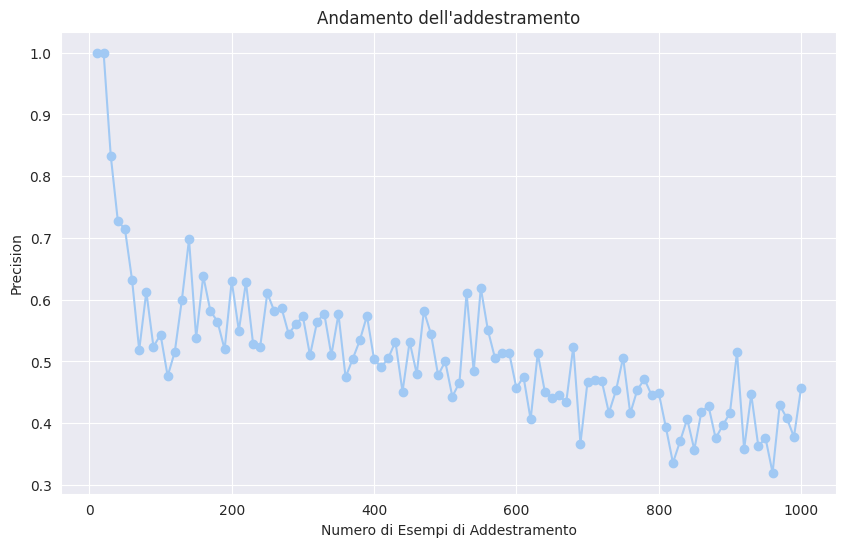

In [ ]:
train_and_plot_limited_data(Perceptron(class_weight='balanced', random_state=30), X_train, y_train, precision_score, "Precision", max_samples=1000)

Osservazione sulle curve di addestramento per il percettrone:

- <p align="justify">CURVA DI TRAIN SU PRECISION: la curva della precision per il percettrone sembra risentire il problema dello sbilanciamento e non sembrano esserci notevoli miglioramenti.

## ADDESTRAMENTO E CONFRONTO TRA I MODELLI CON COST SENSITIVE
Procediamo all'addestramento dei modelli e al confronto delle loro performance tramite le metriche di valutazione.

In [31]:
# istanziazzione dei modelli da mettere a confronto
sgdc_cs = SGDClassifier(loss='log', class_weight='balanced', random_state=30)
perceptron_cs = Perceptron(class_weight='balanced', random_state=30)

# adestramento base su hold-out per stochastic gradient descent
sgdc_cs.fit(X_train, y_train)
pred_train_sgdc_cs = sgdc_cs.predict(X_train)
pred_test_sgdc_cs = sgdc_cs.predict(X_test)


# adestramento base su hold-out per percettrone
perceptron_cs.fit(X_train, y_train)
pred_train_perceptron_cs = perceptron_cs.predict(X_train)
pred_test_perceptron_cs = perceptron_cs.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


In [32]:
# Utilizzo della funzione per mostrare le predizioni a confronto tra train e test
stampa_metriche(pred_train_sgdc_cs, pred_test_sgdc_cs, y_train, y_test, "STOCHASTIC GRADIENT DESCENT")

----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------
Modello valutato: STOCHASTIC GRADIENT DESCENT
Accuracy (Train): 0.748928469378036
Accuracy (Test): 0.7455555555555555
Precision (Train): 0.6971331694508418
Precision (Test): 0.6922670082684298
Recall (Train): 0.7538366151217661
Recall (Test): 0.7531568888033173
F1-Score (Train): 0.7059717036201456
F1-Score (Test): 0.7005226685885912
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      7977
           1       0.49      0.76      0.59      2522

    accuracy                           0.75     10499
   macro avg       0.70      0.75      0.71     10499
weighted avg       0.81      0.75      0.76     10499

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.91      0.74      0.82      3451
           1       0.47      0.77      0.58      1049

    accuracy                           0.75      4500


I risultati che si riscontrano tra train e test sono abbastanza simili, anche se almeno in questo caso si sono avuti dei lievissimi peggioramenti sul test cosa più che comprensibile.

In [33]:
print("_______STOCHASTIC GRADIENT DESCENT COST SENSITIVE_______")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_test_sgdc_cs))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_test_sgdc_cs))

_______STOCHASTIC GRADIENT DESCENT COST SENSITIVE_______
------------------------Accuracy------------------------

0.7455555555555555

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.91      0.74      0.82      3451
           1       0.47      0.77      0.58      1049

    accuracy                           0.75      4500
   macro avg       0.69      0.75      0.70      4500
weighted avg       0.81      0.75      0.76      4500



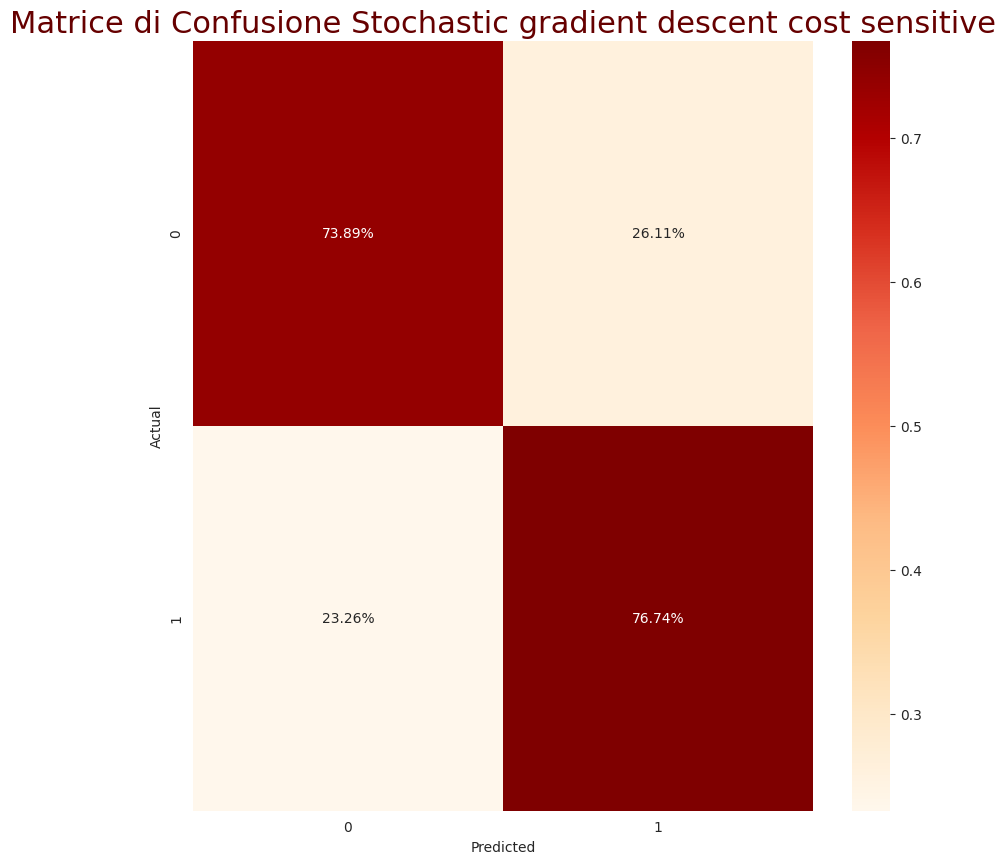

In [ ]:
plot_confusion_matrix(y_test, pred_test_sgdc_cs, "Matrice di Confusione Stochastic gradient descent cost sensitive")

Studiamo quale sia il miglior k fold in base alle metriche di recall e precision per effettuare la convalida incrociata

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

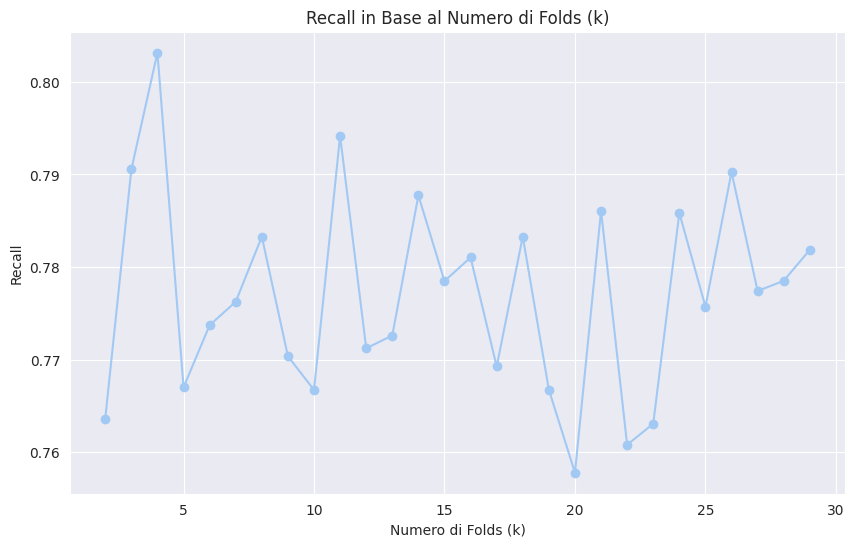

In [34]:
kfold_crossval_plot(X_array, y_array, SGDClassifier(loss='log', class_weight='balanced', random_state=30), recall_score, "Recall", range(2,30))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skle

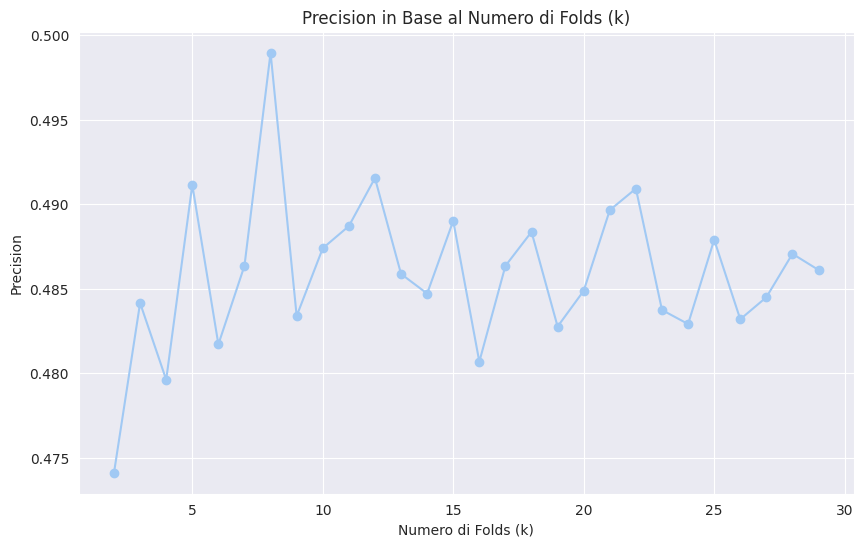

In [35]:
kfold_crossval_plot(X_array, y_array, SGDClassifier(loss='log', class_weight='balanced', random_state=30), precision_score, "Precision", range(2,30))

Andiamo a verificare i precedenti risultati ottenuti con hold out con  convalida incrociata andando ad utilizzare il miglior fold k trovato in precedenza

In [36]:
sdgc_cs_basal_cv_score = cross_val_score(SGDClassifier(loss='log', class_weight='balanced', random_state=30), X, y, cv=4, scoring='recall')
print("Stochastic Gradient Descent cost sensitive Cross Validation Recall scores are: {}".format(sdgc_cs_basal_cv_score))
print("Stocastic Gradient Descent cost sensitive Average Cross Validation Recall score: {}".format(sdgc_cs_basal_cv_score.mean()))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Stochastic Gradient Descent cost sensitive Cross Validation Recall scores are: [0.74244121 0.78163494 0.76931691 0.83632287]
Stocastic Gradient Descent cost sensitive Average Cross Validation Recall score: 0.7824289817665048


La convalida incrociata va a convermare i risultati ottenuti con il precedente addestramento tramite hold out

In [ ]:
# Utilizzo della funzione per mostrare le predizioni a confronto tra train e test
stampa_metriche(pred_train_perceptron_cs, pred_test_perceptron_cs, y_train, y_test, "PERCETTRONE")

----------CONFRONTO PERFORMANCE TRAIN VS TEST-----------
Modello valutato: PERCETTRONE
Accuracy (Train): 0.7434041337270216
Accuracy (Test): 0.7562222222222222
Precision (Train): 0.6572476494484065
Precision (Test): 0.6708440530377994
Recall (Train): 0.6699406759938391
Recall (Test): 0.6907737882306533
F1-Score (Train): 0.6625576952811082
F1-Score (Test): 0.6786442242963715
Classification Report (Train):
               precision    recall  f1-score   support

           0       0.84      0.81      0.83      7977
           1       0.47      0.53      0.50      2522

    accuracy                           0.74     10499
   macro avg       0.66      0.67      0.66     10499
weighted avg       0.75      0.74      0.75     10499

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.86      0.81      0.84      3451
           1       0.48      0.57      0.52      1049

    accuracy                           0.76      4500
   macro avg   

In questo caso come nell'addestramento con cost insensitive c'è puzza di bruciato infatti ccome mostrato dal report le performance sul test risultano migliori di quelle sul train caso alquanto insolito.

In [ ]:
print("_______________PERCETTRONE COST SENSITIVE_______________")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_test_perceptron_cs))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_test_perceptron_cs))

_______________PERCETTRONE COST SENSITIVE_______________
------------------------Accuracy------------------------

0.7562222222222222

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.86      0.81      0.84      3451
           1       0.48      0.57      0.52      1049

    accuracy                           0.76      4500
   macro avg       0.67      0.69      0.68      4500
weighted avg       0.77      0.76      0.76      4500



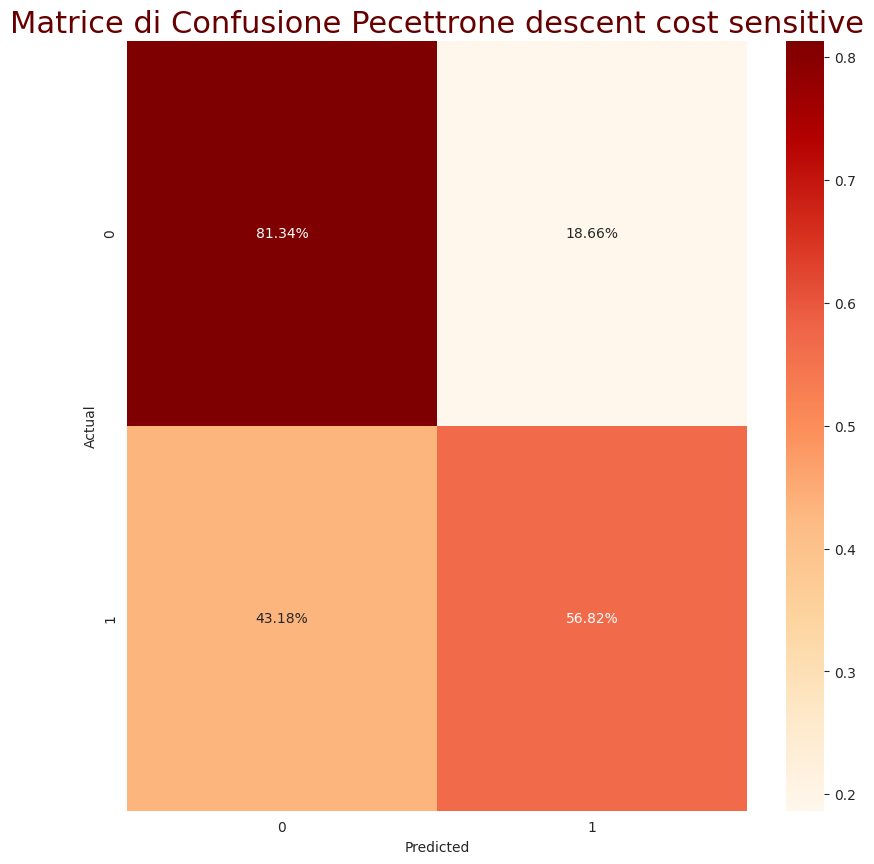

In [ ]:
plot_confusion_matrix(y_test, pred_test_perceptron_cs, "Matrice di Confusione Pecettrone descent cost sensitive")

Andiamo a studiare il miglior fold k per la convaalida incrociata per il percettrone addestrato con cost sensitive

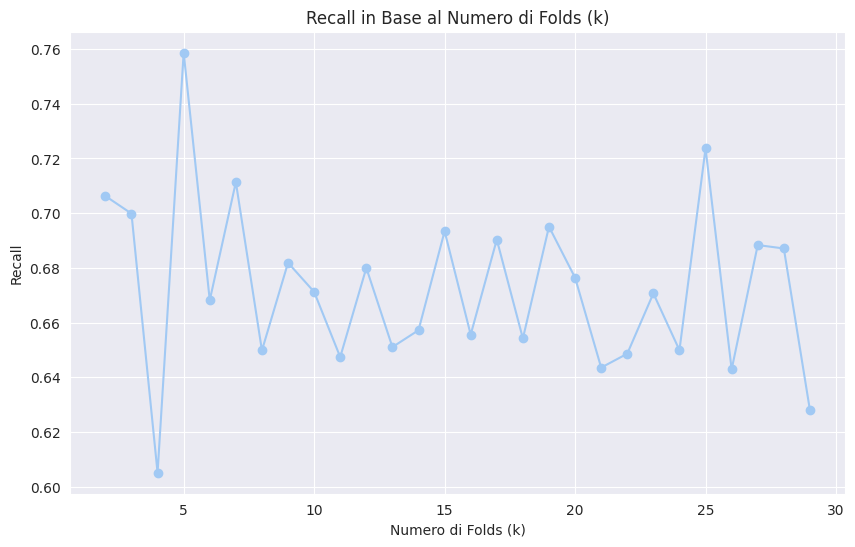

In [37]:
kfold_crossval_plot(X_array, y_array, Perceptron(class_weight='balanced', random_state=30), recall_score, "Recall", range(2,30))

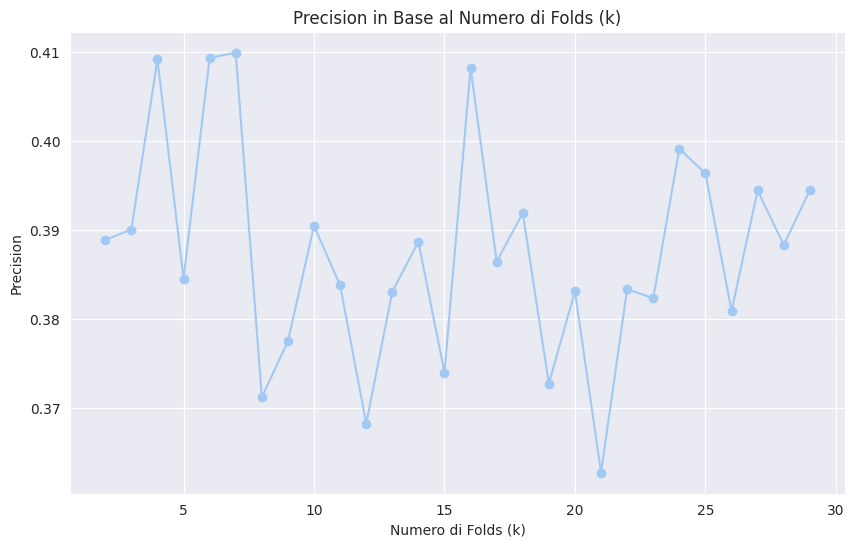

In [38]:
kfold_crossval_plot(X_array, y_array, Perceptron(class_weight='balanced', random_state=30), precision_score, "Precision", range(2,30))

Eseguiamo la convalida incrociata utilizzando il miglior k per i fold trovato con lo studio fatto in precedenza sui grafici in base alle metriche di recall e precision.

In [40]:
percettrone_cs_basal_cv_score = cross_val_score(Perceptron(class_weight='balanced', random_state=30), X, y, cv=5, scoring='recall')
print("Percettrone cost sensitive Cross Validation Recall scores are: {}".format(percettrone_cs_basal_cv_score))
print("Percettrone cost sensitive Average Cross Validation Recall score: {}".format(percettrone_cs_basal_cv_score .mean()))

Percettrone cost sensitive Cross Validation Recall scores are: [0.7745098  0.77030812 0.52941176 0.75524476 0.73389356]
Percettrone cost sensitive Average Cross Validation Recall score: 0.7126736009088951


La convalida incrociata per il percettrone non convalida l'hold out in quanto in media con la convalida incrociata con k=5 si sono ottenuti risultati di gran lunga superiori a quelli ottenuti con l0hold out.

- CURVA ROC: Mettiamo a confronto i 2 classificatori addestrati dopo aver applicato un addestramentto sensibile alla classe minoritaria e vedere i risultati che abbiamo ottenuto.

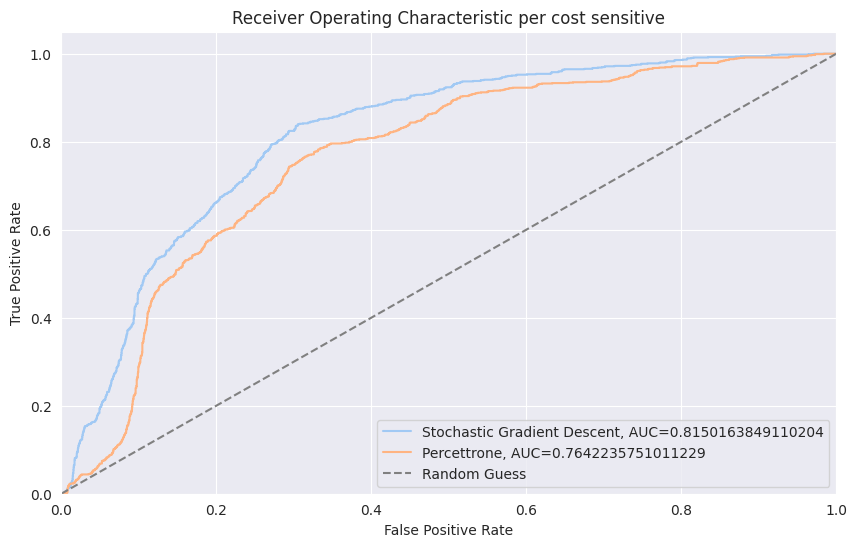

In [41]:
# Calcola i punteggi delle probabilità positive
pred_sgdc_cs_positive = sgdc_cs.predict_proba(X_test)[:, 1]
pred_perceptron_cs_positive = perceptron_cs.decision_function(X_test)

# Calcola le curve ROC e gli AUC
fpr_sgdc_cs, tpr_sgdc_cs, _ = roc_curve(y_test, pred_sgdc_cs_positive)
auc_sgdc_cs = roc_auc_score(y_test, pred_sgdc_cs_positive)

fpr_perceptron_cs, tpr_perceptron_cs, _ = roc_curve(y_test, pred_perceptron_cs_positive)
auc_perceptron_cs = roc_auc_score(y_test, pred_perceptron_cs_positive)

# Crea il grafico ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_sgdc_cs, tpr_sgdc_cs, label="Stochastic Gradient Descent, AUC=" + str(auc_sgdc_cs))
plt.plot(fpr_perceptron_cs, tpr_perceptron_cs, label="Percettrone, AUC=" + str(auc_perceptron_cs))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic per cost sensitive')
plt.legend(loc='lower right')
plt.show()

- CONCLUSIONI: <p align="justify"> Dopo aver terminato l'addestramento con cost sensitive confrontando i risultati ottenuti sulle metriche valutate per misurare le performance dei due classificatori e come è possibile notare dalle curve del grafico del receiver operator characteristic lo stochastic gradient descent batte notevolmente il percettrone, dichiarandosi il modello migliore tra i due.

## OTTIMIZZAZIONE DEI MODELLI
In questo notebook l'ottimizzazione dei modelli verrà affrontatta solo per il cost-sensitive visto e considerato che per quanto fino ad ora osservato il cost-sensitive migliora l'apprendimento andiamo direttamento a ottimizzare i modelli in questa situazione.

In [42]:
kf5 = StratifiedKFold(n_splits=5, shuffle=False)
kf10 = StratifiedKFold(n_splits=10, shuffle=False)
kf15 = StratifiedKFold(n_splits=15, shuffle=False)

In [43]:
param_grid_sgdc_cs = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
     'class_weight': ['balanced'] ,
    'loss': ["hinge", "perceptron", "modified_huber"],
    'penalty': ['none', 'l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 0.2, 0.3, 0.4],
    'max_iter': [100, 200, 300, 400, 500],
}

In [44]:
grid_sgdc_cs = GridSearchCV(SGDClassifier(), param_grid=param_grid_sgdc_cs, cv=4, scoring='recall').fit(X_train, y_train)
print('Best parameters:', grid_sgdc_cs.best_params_)
print('Best score:', grid_sgdc_cs.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic

Best parameters: {'alpha': 0.1, 'class_weight': 'balanced', 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'perceptron', 'max_iter': 500, 'penalty': 'l1'}
Best score: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
6000 fits failed out of a total of 24000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6000 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py", line 891, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dis

In [46]:
pred_grid_sgdc_cs  = grid_sgdc_cs.predict(X_test)


print("__STOCHASTIC GRADIENT DESCENT ON KCV=10 COST SENSITIVE__")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_grid_sgdc_cs))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_grid_sgdc_cs))

__STOCHASTIC GRADIENT DESCENT ON KCV=10 COST SENSITIVE__
------------------------Accuracy------------------------

0.7668888888888888

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3451
           1       0.00      0.00      0.00      1049

    accuracy                           0.77      4500
   macro avg       0.38      0.50      0.43      4500
weighted avg       0.59      0.77      0.67      4500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


L'ottimizzazione ha migliorato le performance dello stochastic gradient descent per quanto riguarda la prima classe ovvero quella dei dipendenti che restano, ma non capisco cosa sia successo con i risultati della seconda classe quelli che lasciano il posto di lavoro.

In [47]:
best_param_SGDC_CS = grid_sgdc_cs.best_params_

In [58]:
sgdc_cs_cv_score = cross_val_score(SGDClassifier(**best_param_SGDC_CS), X, y, cv=4, scoring='recall')
print("Stochastic Gradient Descent Best param Cross Validation Recall scores are: {}".format(sgdc_cs_cv_score))
print("Stochastic Gradient Descent Best param Average Cross Validation Recall score: {}".format(sgdc_cs_cv_score.mean()))

Stochastic Gradient Descent Best param Cross Validation Recall scores are: [1.         1.         1.         0.77242152]
Stochastic Gradient Descent Best param Average Cross Validation Recall score: 0.9431053811659192


In [59]:
param_grid_perceptron_cs = {
    'penalty': [None, 'l2', 'l1', 'elasticnet'],  # Tipo di regolarizzazione
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],   # Termine di regolarizzazione
    'fit_intercept': [True, False],              # Interceptarlo o meno
    'max_iter': [100, 200, 300, 400],       # Numero massimo di iterazioni
    'tol': [1e-3, 1e-4, 1e-5],                  # Tolleranza per l'arresto
    'eta0': [0.01, 0.1, 0.2, 0.3, 0.4],         # Tasso di apprendimento iniziale
    'class_weight': ['balanced'],  # Gestione del costo
    'warm_start': [True, False],                 # Riutilizza la soluzione precedente
}

In [60]:
grid_perceptron_cs = GridSearchCV(Perceptron(), param_grid=param_grid_perceptron_cs, cv=5, scoring='recall').fit(X_train, y_train)
print('Best parameters:', grid_perceptron_cs.best_params_)
print('Best score:', grid_perceptron_cs.best_score_)

Best parameters: {'alpha': 0.1, 'class_weight': 'balanced', 'eta0': 0.3, 'fit_intercept': True, 'max_iter': 100, 'penalty': 'l1', 'tol': 0.001, 'warm_start': True}
Best score: 0.9797619047619047


In [61]:
pred_perceptron_cs  = grid_perceptron_cs.predict(X_test)


print("__________PERCEPTRON ON KCV=10 COST SENSITIVE___________")
print("------------------------Accuracy------------------------")
print()
print(accuracy_score(y_test, pred_perceptron_cs))
print()
print("------------------Classification_Report-----------------")
print()
print(classification_report(y_test, pred_perceptron_cs))

__________PERCEPTRON ON KCV=10 COST SENSITIVE___________
------------------------Accuracy------------------------

0.6897777777777778

------------------Classification_Report-----------------

              precision    recall  f1-score   support

           0       0.89      0.68      0.77      3451
           1       0.41      0.73      0.52      1049

    accuracy                           0.69      4500
   macro avg       0.65      0.70      0.65      4500
weighted avg       0.78      0.69      0.71      4500



L'ottimizzazione del percettrone ha portato a dei migliorameenti nelle performance del classificatore anche se sul rilevamento dei migliori parametri si era dimostrato andare meglio.

In [62]:
best_param_PERCEPTRON = grid_perceptron_cs.best_params_

In [63]:
perceptron_cs_cv_score = cross_val_score(Perceptron(**best_param_PERCEPTRON), X, y, cv=kf5, scoring='recall')
print("Perceptron Best param Cross Validation Recall scores are: {}".format(perceptron_cs_cv_score))
print("Perceptron Best param Average Cross Validation Recall score: {}".format(perceptron_cs_cv_score.mean()))

Perceptron Best param Cross Validation Recall scores are: [0.71288515 0.         0.70588235 0.         0.73809524]
Perceptron Best param Average Cross Validation Recall score: 0.4313725490196079


## CONFRONTO COST SENSITIVE VS COST INSENSITIVE SU ROC:
adremo aplottare i risultati ottenuti dalla nostra sperimentazione delle metodologie per affrontare l'imballance learniong e in particolare andreo a creare un grafico che metta in evidenza lo score ROC e AUROC per i classificatori addestrati.

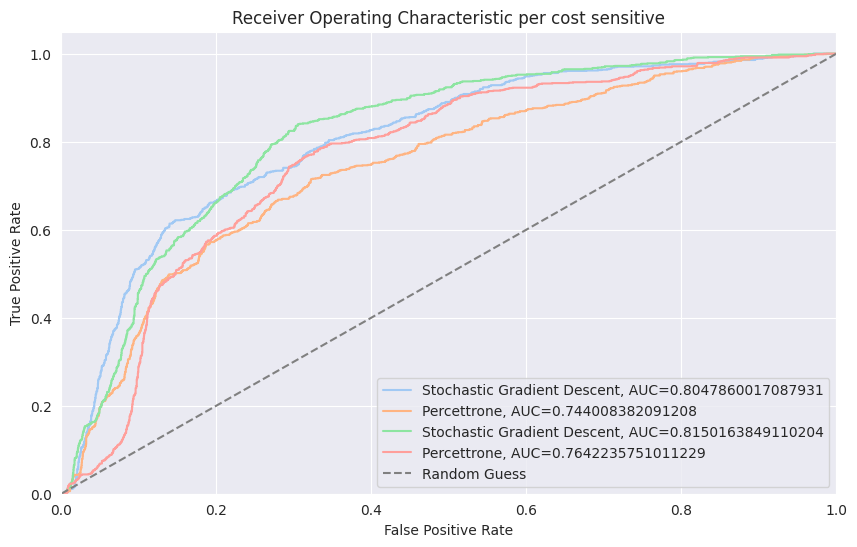

In [64]:
# Crea il grafico ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr_sgdc, tpr_sgdc, label="Stochastic Gradient Descent, AUC=" + str(auc_sgdc))
plt.plot(fpr_perceptron, tpr_perceptron, label="Percettrone, AUC=" + str(auc_perceptron))
plt.plot(fpr_sgdc_cs, tpr_sgdc_cs, label="Stochastic Gradient Descent, AUC=" + str(auc_sgdc_cs))
plt.plot(fpr_perceptron_cs, tpr_perceptron_cs, label="Percettrone, AUC=" + str(auc_perceptron_cs))
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic per cost sensitive')
plt.legend(loc='lower right')
plt.show()

#### CONCLUSIONI STUDIO SUL COST SENSITIVE LEARNING
<p align="justify"> Dallo studio condotto abbiamo capito che affrontare un task di classificazione sbilanciato con strategia cost sensitive learning migliora le performance del classificatore e in particolare migliora le performnce sulla classe minoritaria di nostro interesse.